In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from inxss.experiment import NeutronExperiment

In [3]:
incident_energy = 260

In [12]:
spinw_data = torch.load('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Sep13.pt')
print(spinw_data.keys())

dict_keys(['Syy', 'Szz', 'S', 'w_grid', 'q_grid', 'params'])


In [40]:
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV.pt')
print(data.keys())

dict_keys(['grid', 'S', 'background', 'scale', 'scale_separator'])


### setup experiment simulator

In [5]:
neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)
neutron_exp.prepare_experiment(hklw_grid)

In [7]:
hklw_grid.shape

torch.Size([121, 121, 30, 66, 4])

In [55]:
idx = 10

In [56]:
sim_exp = SimulatedExperiment(
    q_grid = spinw_data['q_grid'],
    w_grid = spinw_data['w_grid'],
    Syy_grid = spinw_data['Syy'][idx],
    Szz_grid = spinw_data['Szz'][idx]
)

In [57]:
sim_exp.prepare_experiment(hklw_grid)

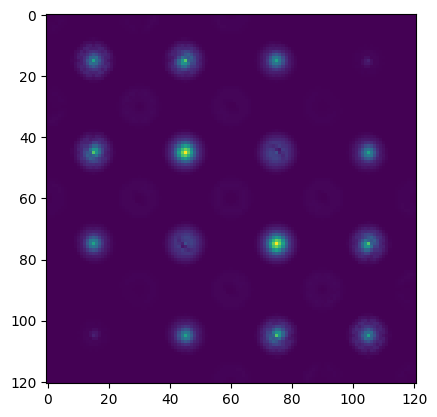

In [58]:
plt.imshow((sim_exp.Sqw * mask_exp).sum(-1).sum(-1))

In [59]:
mask_exp = neutron_exp.Sqw > 1e-10

In [60]:
Sqw_sm = gaussian_filter(sim_exp.Sqw.numpy(), sigma=0.75)

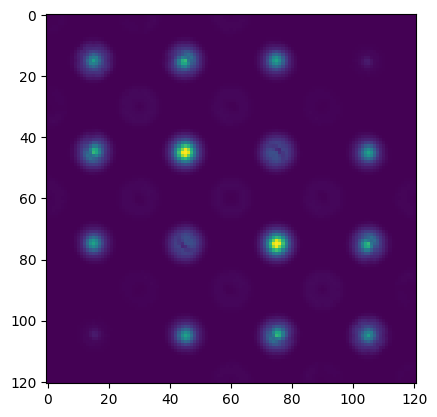

In [61]:
plt.imshow((Sqw_sm * mask_exp.numpy()).sum(-1).sum(-1))

In [62]:
Sqw_exp = data['S'] - data['background']

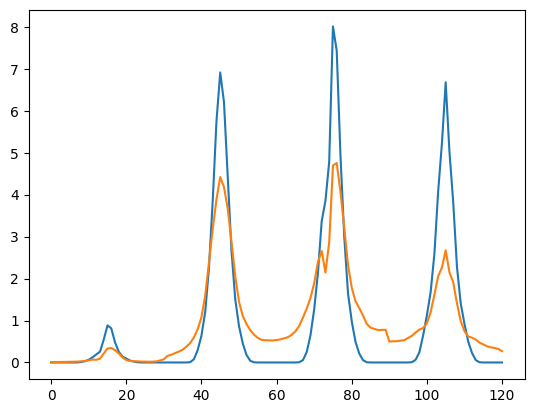

In [63]:
plt.plot((Sqw_sm * mask_exp.numpy()).sum(-1).sum(-1)[:,105] / (Sqw_sm * mask_exp.numpy()).sum(-1).sum(-1)[:,105].mean())
plt.plot(Sqw_exp.sum(-1).sum(-1)[:,105] / Sqw_exp.sum(-1).sum(-1)[:,105].mean())

### setup neural network model

In [6]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896843/checkpoints/epoch=1165-step=55968.ckpt'
    ).to(device)

# model = SpecNeuralRepr.load_from_checkpoint(
#     '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896844/checkpoints/epoch=1005-step=48288.ckpt'
#     )

In [7]:
# sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1)
sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1) / (neutron_exp.Sqw > 1).sum(-1).sum(-1)
# sqw_disp = data['S'].sum(-1).sum(-1) / (data['S'] > 1e-3).sum(-1).sum(-1)

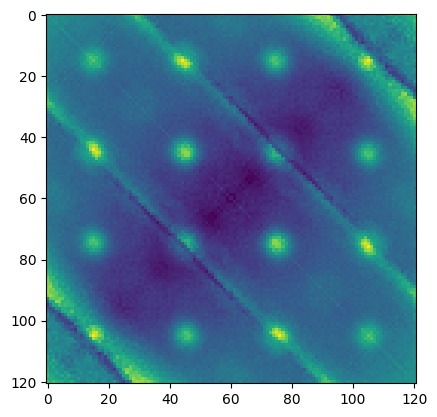

In [8]:
plt.imshow(sqw_disp)

In [9]:
# x_input = torch.zeros(hklw_grid.shape[:-1]+(5,))

# x_input[...,:3] = hklw_grid[...,[0,1,3]]
# x_input[...,3:] = torch.tensor([29.0, 1.68])

# s_pred = []
# k = 0
# with torch.no_grad():
#     for _x_input in tqdm(x_input.permute(3,0,1,2,4).reshape((-1, hklw_grid.shape[0], hklw_grid.shape[1], hklw_grid.shape[2], 5,))):
#         # print(_x_input.shape)
#         _y_output = model(_x_input.to(device), l=hklw_grid[...,k,[2]].to(device)).detach().cpu().numpy()
#         s_pred.append(_y_output)
#         k += 1
#         # break
# s_pred = np.moveaxis(np.stack(s_pred), 0, -1)

100%|██████████| 66/66 [00:03<00:00, 18.58it/s]


In [24]:
s_pred = sim_exp.Sqw.numpy().copy()

In [29]:
mask_exp = neutron_exp.Sqw > 1e-10
# s_pred_masked = s_pred * mask_exp.cpu().numpy()
# s_pred_disp = s_pred.sum(-1).sum(-1) / (s_pred >  1e-4*s_pred.max()).sum(-1).sum(-1)
mask_pred = (s_pred > 1e-4*s_pred.max()) * mask_exp.cpu().numpy()
s_pred_masked = s_pred * mask_pred

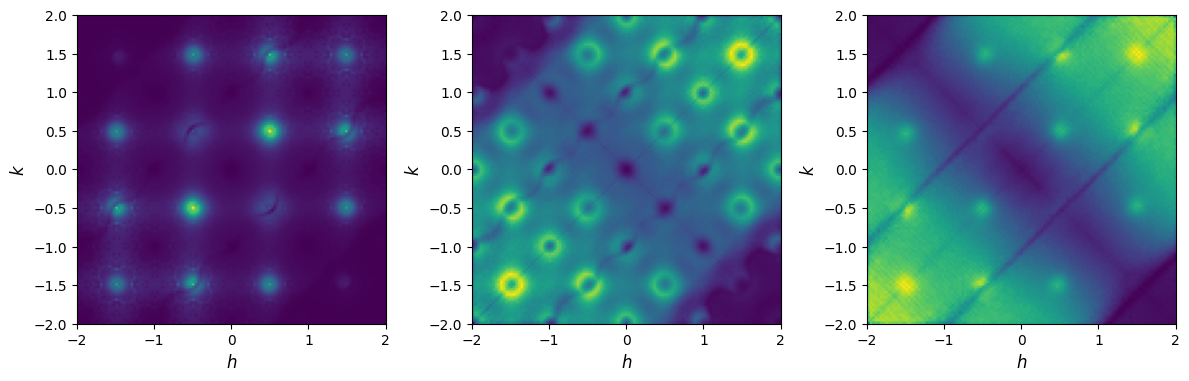

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow(mask_pred.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()


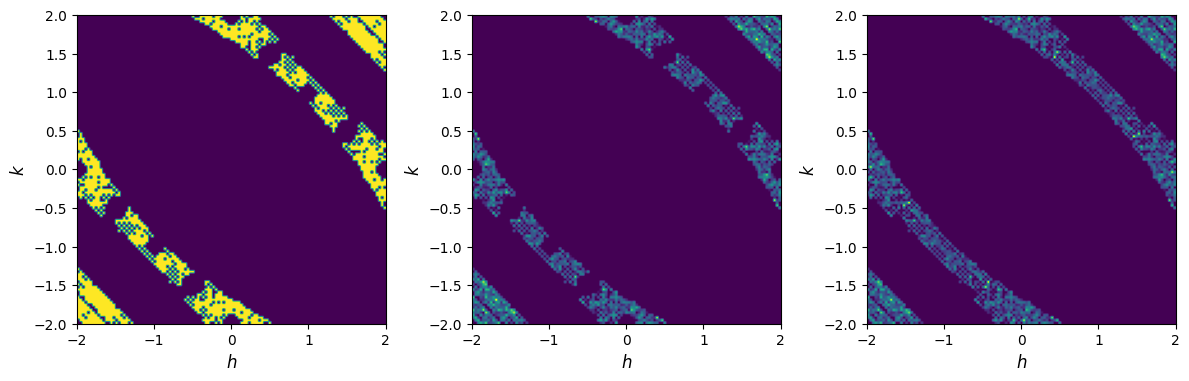

In [31]:
# background is those where experiment coverage is available (first)
# while no magnetic signal is present (second)
mask_background = (neutron_exp.Sqw.cpu().numpy() > 1e-10) * (s_pred <= 1e-4*s_pred.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(mask_background[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)
ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy() * mask_background)[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)
ax = axes[2]
ax.imshow((neutron_exp.Sqw.cpu().numpy())[...,0,5].T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

In [32]:
total_signal = neutron_exp.Sqw.cpu().numpy()

s_pred_masked_sm = gaussian_filter(s_pred_masked, sigma=0.75)
# s_pred_masked

In [33]:
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [34]:
q_inner_mid = 1.0
q_mid_outer = 1.8

mask_inner = (hklw_grid[...,:2].norm(dim=-1) <= q_inner_mid).numpy() * mask_pred
mask_mid = (hklw_grid[...,:2].norm(dim=-1) >  q_inner_mid).numpy() * (hklw_grid[...,:2].norm(dim=-1) <=  q_mid_outer).numpy() * mask_pred
mask_outer = (hklw_grid[...,:2].norm(dim=-1) >  q_mid_outer).numpy() * mask_pred

In [35]:
scale_factor_list = np.linspace(200, 400, 50)
inner_pc_sim_list = []
mid_pc_sim_list = []
outer_pc_sim_list = []

for scale_factor in tqdm(scale_factor_list):
    # pc_exp_list.append(pearsonr(total_signal[mask_pred], total_signal[mask_pred] - scale_factor * s_pred_masked[mask_pred]).statistic)
    inner_pc_sim_list.append(pearsonr(s_pred_masked[mask_inner], total_signal[mask_inner] - scale_factor * s_pred_masked_sm[mask_inner]).statistic)
    mid_pc_sim_list.append(pearsonr(s_pred_masked[mask_mid], total_signal[mask_mid] - scale_factor * s_pred_masked_sm[mask_mid]).statistic)
    outer_pc_sim_list.append(pearsonr(s_pred_masked[mask_outer], total_signal[mask_outer] - scale_factor * s_pred_masked_sm[mask_outer]).statistic)
    # break

100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


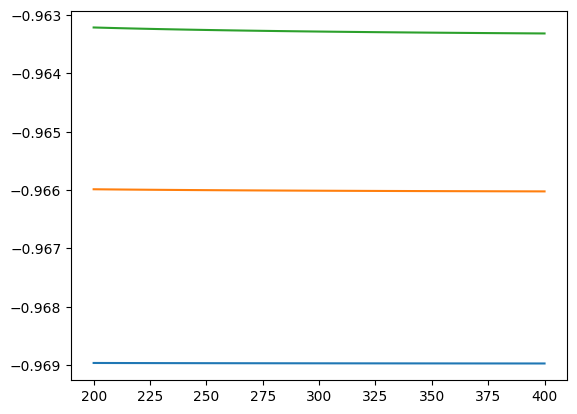

In [36]:
# plt.plot(scale_factor_list, pc_exp_list)
plt.plot(scale_factor_list, inner_pc_sim_list)
plt.plot(scale_factor_list, mid_pc_sim_list)
plt.plot(scale_factor_list, outer_pc_sim_list)

In [18]:
inner_pc_func = interp1d(scale_factor_list, inner_pc_sim_list)
mid_pc_func = interp1d(scale_factor_list, mid_pc_sim_list)
outer_pc_func = interp1d(scale_factor_list, outer_pc_sim_list)

In [19]:
opt_inner_scale_factor = fsolve(inner_pc_func, 280)
print("best scale factor for inner q-region: ", opt_inner_scale_factor)
opt_mid_scale_factor = fsolve(mid_pc_func, 280)
print("best scale factor for mid q-region: ", opt_mid_scale_factor)
try:
    opt_outer_scale_factor = fsolve(outer_pc_func, 280)
except:
    opt_outer_scale_factor = 0.
print("best scale factor for outer q-region: ", opt_outer_scale_factor)

best scale factor for inner q-region:  [244.92956824]
best scale factor for mid q-region:  [364.69520572]
best scale factor for outer q-region:  [237.14812453]


In [20]:
background = total_signal.copy()

In [21]:
background[mask_inner] = total_signal[mask_inner] - opt_inner_scale_factor * s_pred_masked_sm[mask_inner]
background[mask_mid] = total_signal[mask_mid] - opt_mid_scale_factor * s_pred_masked_sm[mask_mid]
background[mask_outer] = total_signal[mask_outer] - opt_outer_scale_factor * s_pred_masked_sm[mask_outer]

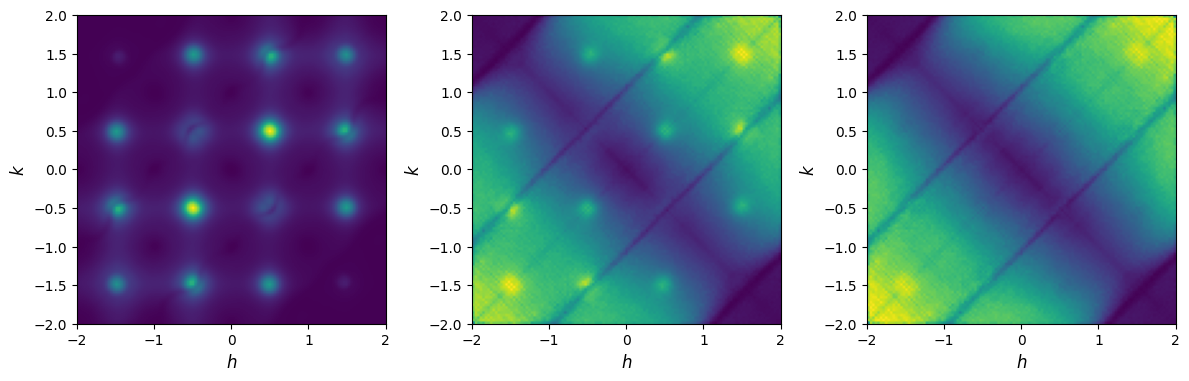

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked_sm.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow(background.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

Text(0, 0.5, '$k$')

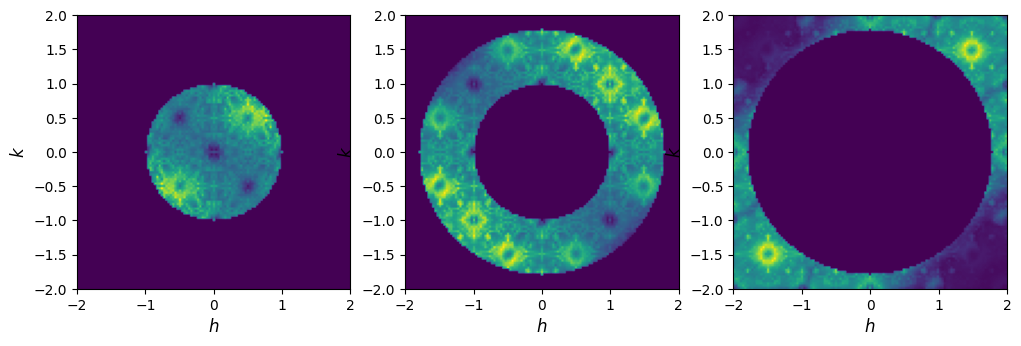

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(mask_inner.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow(mask_mid.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[2]
ax.imshow(mask_outer.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

In [24]:
data_w_bkg = {key: val for (key, val) in data.items()}

In [25]:
data_w_bkg['background'] = background

In [26]:
data_w_bkg['scale'] = {key: {'scale_factor': None, 'scale_mask': None} for key in ['inner', 'mid', 'outer']}

In [27]:
for key in data_w_bkg['scale'].keys():
    data_w_bkg['scale'][key]['scale_factor'] = eval(f'opt_{key}_scale_factor[0]')
    data_w_bkg['scale'][key]['scale_mask'] = eval(f'torch.from_numpy(mask_{key})')

In [28]:
data_w_bkg['scale_separator'] = {'inner_mid': q_inner_mid, 'mid_outer': q_mid_outer}

In [29]:
# torch.save(data_w_bkg, f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV.pt')